# The use of Principal Component Analysis to improve the performance of a Simple Classifier

## Defining High-Dimensional Data in Data Science
High-dimensional data refers to datasets with a very large number of features or variables relative to the number of observations. Whereas traditional datasets may have 10s or 100s of features, high-dimensional datasets can have 1000s or even millions of features.

## Curse of Dimensionality and Its Implications
As the number of dimensions or features in a dataset increases, the volume of hyperspace grows exponentially. This presents several issues:

* Models require more data points to make accurate predictions and avoid overfitting. 
* Collecting quality, representative data becomes more difficult. 
* Irrelevant features can negatively impact model performance. Feature selection becomes critical. 
* Traditional algorithms struggle to operate in high-dimensional spaces efficiently. More advanced methods are needed.
Overall, increased dimensions introduce complexity that standard data analysis techniques fail to handle effectively.

For more click [here](https://dataheadhunters.com/academy/high-dimensional-data-challenges-and-strategies-for-analysis/)

## Principal Component Analysis 

Principal Component Analysis (PCA) is a statistical technique used to simplify high-dimensional data by reducing the number of variables while preserving as much information as possible. It does this by transforming the data into a new coordinate system where the axes represent the directions of maximum variance in the data. 

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/anaemia-prediction/output.csv


In [2]:
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix,ConfusionMatrixDisplay, precision_recall_fscore_support, precision_score, recall_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, KernelPCA

rs = 80

## About the data
This dataset is curated to facilitate the development of machine learning models aimed at predicting anaemia based on hemoglobin levels and color pixel distribution from associated images. Each row in the dataset corresponds to an individual case with various features. 

With 7 columns and 104 observations, this data set DO NOT exactly pass for a high dimensional data. However, for the sake of practice and because this is a topic that piqued my interest - mostly due to my background in Biochemistry - I will proceed with the analysis.

In [3]:
data = pd.read_csv('/kaggle/input/anaemia-prediction/output.csv')
data.head()

,Number,Sex,%Red Pixel,%Green pixel,%Blue pixel,Hb,Anaemic
0,1,M,43.2555,30.8421,25.9025,6.3,Yes
1,2,F,45.6033,28.1900,26.2067,13.5,No
2,3,F,45.0107,28.9677,26.0215,11.7,No
3,4,F,44.5398,28.9899,26.4703,13.5,No
4,5,M,43.2870,30.6972,26.0158,12.4,No


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Number        104 non-null    int64  
 1   Sex           104 non-null    object 
 2   %Red Pixel    104 non-null    float64
 3   %Green pixel  104 non-null    float64
 4   %Blue pixel   104 non-null    float64
 5   Hb            104 non-null    float64
 6   Anaemic       104 non-null    object 
dtypes: float64(4), int64(1), object(2)
memory usage: 5.8+ KB


### Description of the variables:
* Number: A unique identifier for each individual case.
* Sex: The sex of the individual.
* %Red Pixel: The percentage of red pixels in the image associated with the case.
* %Green Pixel: The percentage of green pixels in the image associated with the case.
* %Blue Pixel: The percentage of blue pixels in the image associated with the case.
* Hb: Hemoglobin level of the individual, measured in grams per deciliter (g/dL).
* Anaemia: An indicator of anaemia status (1 for anaemic, 0 for not anaemic).

### Data Validation and Cleaning:

* There is some inconsistencies in the 'Sex' columns, trailing white spaces in some of the values.
* Converted 'Anaemia' column to categorical data type 
* Checked for presence of missing values but there's no missing values in the data set
* Renamed the columns to be more meaningful
* Checked for duplicate observations because this will lead to data leakage

In [5]:
data['Sex'].unique()

array(['M', 'F', 'F ', 'M '], dtype=object)

In [6]:
data['Sex'] = data['Sex'].str.strip()
data['Sex'].unique()

array(['M', 'F'], dtype=object)

In [7]:
data['Anaemic'].unique()

array(['Yes', 'No'], dtype=object)

In [8]:
data.rename(columns = {'%Red Pixel':'Red_pixel',
                      '%Green pixel': 'Green_pixel',
                      '%Blue pixel': 'Blue_pixel'}, inplace = True)
data.head()

,Number,Sex,Red_pixel,Green_pixel,Blue_pixel,Hb,Anaemic
0,1,M,43.2555,30.8421,25.9025,6.3,Yes
1,2,F,45.6033,28.1900,26.2067,13.5,No
2,3,F,45.0107,28.9677,26.0215,11.7,No
3,4,F,44.5398,28.9899,26.4703,13.5,No
4,5,M,43.2870,30.6972,26.0158,12.4,No


In [9]:
data.isna().sum()

Number         0
Sex            0
Red_pixel      0
Green_pixel    0
Blue_pixel     0
Hb             0
Anaemic        0
dtype: int64

In [10]:
data.duplicated().sum()

0

In [11]:
data['Anaemic'] = data.Anaemic.astype('category')
data['Anaemic'].dtype

CategoricalDtype(categories=['No', 'Yes'], ordered=False, categories_dtype=object)

## Data Exploration

A quick summary of the data reveals the following:
* The average of percentage of 'Red_pixel' is 45.65 and the median value is 45.39. This median is approximately equal to the mean, which suggests that the variable is approximately normally distributed 
* The average percentage of 'Green_pixel' is 28.88 and the median value is 28.95
* The average percentage of 'Blue_pixel' is 25.47 and the median value 25.95
* The average Hb of the individuals in the dataset is 12.15 and the median value is 12.60

In [12]:
data.describe()

,Number,Red_pixel,Green_pixel,Blue_pixel,Hb
count,104.000000,104.000000,104.000000,104.000000,104.000000
mean,52.500000,45.654175,28.875507,25.470325,12.150962
std,30.166206,2.816294,1.554275,1.984671,2.512957
min,1.000000,38.796800,25.140300,19.541300,2.800000
25%,26.750000,43.911375,27.871300,24.896425,10.650000
50%,52.500000,45.385350,28.948750,25.953200,12.600000
75%,78.250000,46.968325,29.887275,26.721600,14.000000
max,104.000000,54.647800,32.368100,29.841400,16.300000


From the visualizations below, 47% of the individuals captured in the data are males and 53% are females. Also we have more females that are anaemic than males that are.

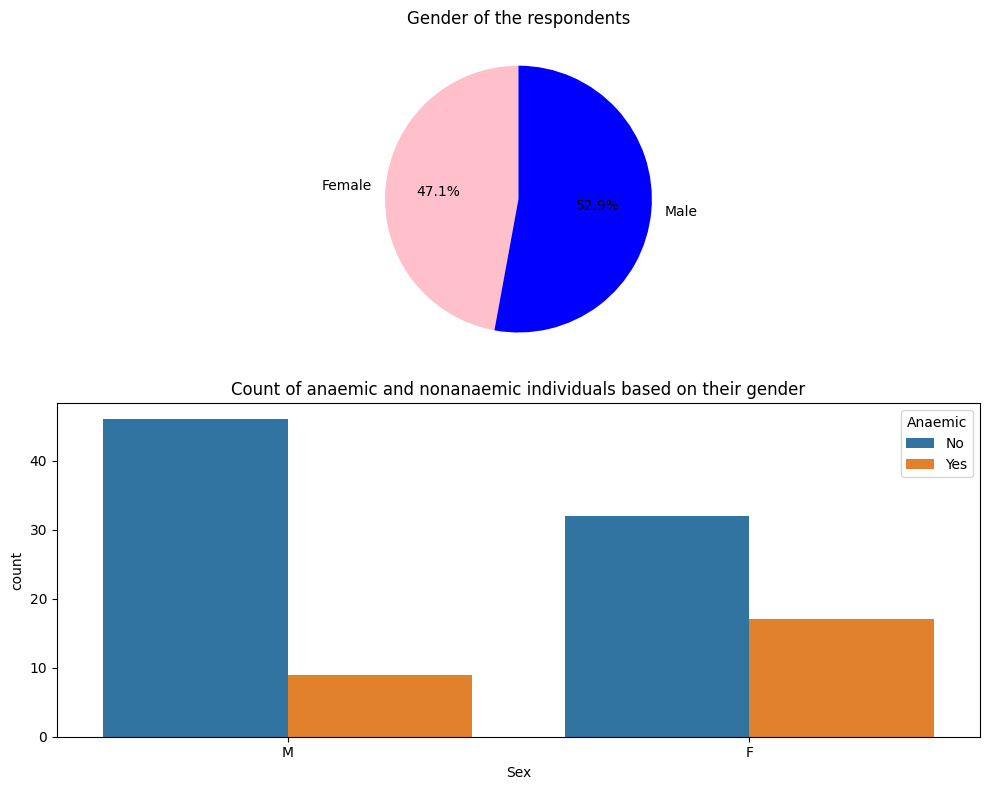

In [13]:
female = data[data['Sex'] == 'F'].shape[0]
male = data[data['Sex'] == 'M'].shape[0]

plt.figure(figsize = (10,8))

plt.subplot(2,1,1)
plt.title('Gender of the respondents')
plt.pie([female, male],
        labels = ['Female', 'Male'],
        autopct = '%1.1f%%',
        startangle = 90,
        colors = ['pink', 'blue']
       )

plt.subplot(2,1,2)
plt.title('Count of anaemic and nonanaemic individuals based on their gender')
sns.countplot(data = data, x = 'Sex', hue = 'Anaemic')

plt.tight_layout()
plt.show()

From the visualisation below, 25% of the individuals captured in the data set are anaemic while 75% are not

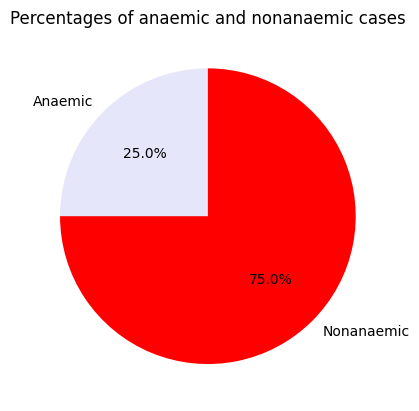

In [14]:
anaemic = data[data['Anaemic'] == 'Yes'].shape[0]
nonanaemic = data[data['Anaemic'] == 'No'].shape[0]

plt.pie([anaemic, nonanaemic],
       labels = ['Anaemic', 'Nonanaemic'],
       autopct = '%1.1f%%', 
       startangle = 90,
       colors = ['lavender', 'red'])
plt.title('Percentages of anaemic and nonanaemic cases')
plt.show()

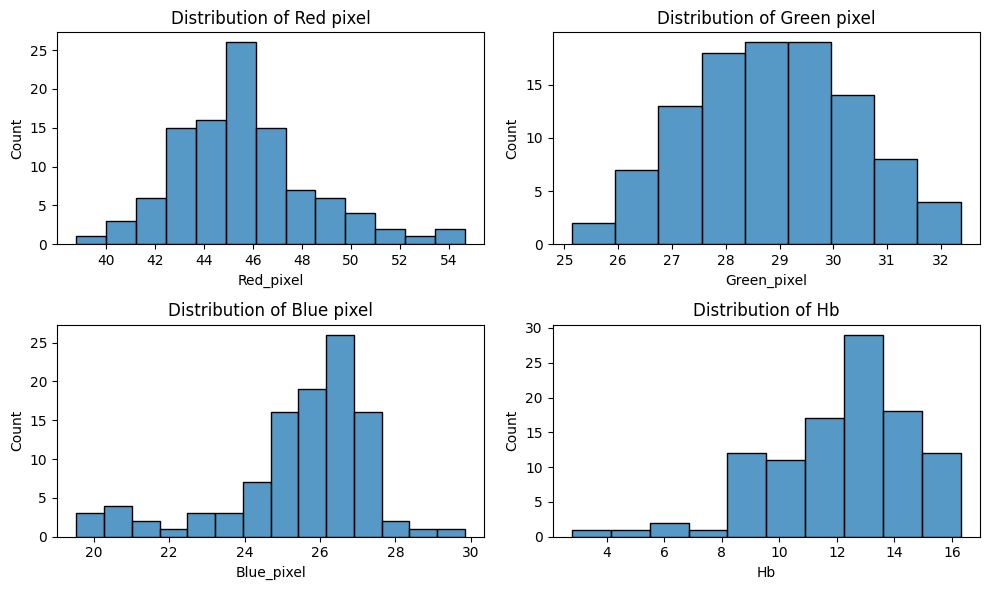

In [15]:
plt.figure(figsize = (10,6))

plt.subplot(2,2,1)
plt.title('Distribution of Red pixel')
sns.histplot(data = data, x = 'Red_pixel')

plt.subplot(2,2,2)
plt.title('Distribution of Green pixel')
sns.histplot(data = data, x = 'Green_pixel')

plt.subplot(2,2,3)
plt.title('Distribution of Blue pixel')
sns.histplot(data = data, x = 'Blue_pixel')

plt.subplot(2,2,4)
plt.title('Distribution of Hb')
sns.histplot(data = data, x = 'Hb')

plt.tight_layout()

plt.show()

From the visualizations above which shows the distributions of the numerical variables 
* Red_pixel: The percentages of blue pixel is approximately normally distributed, this confirms my suspicion earlier
* Green_pixel: The percentages of green pixel is also approximately distributed with values ranging from 28 to 32
* Blue_pixel: This is slightly skewed to the left
* Hb: The distribution of Hb is also skewed to the left 

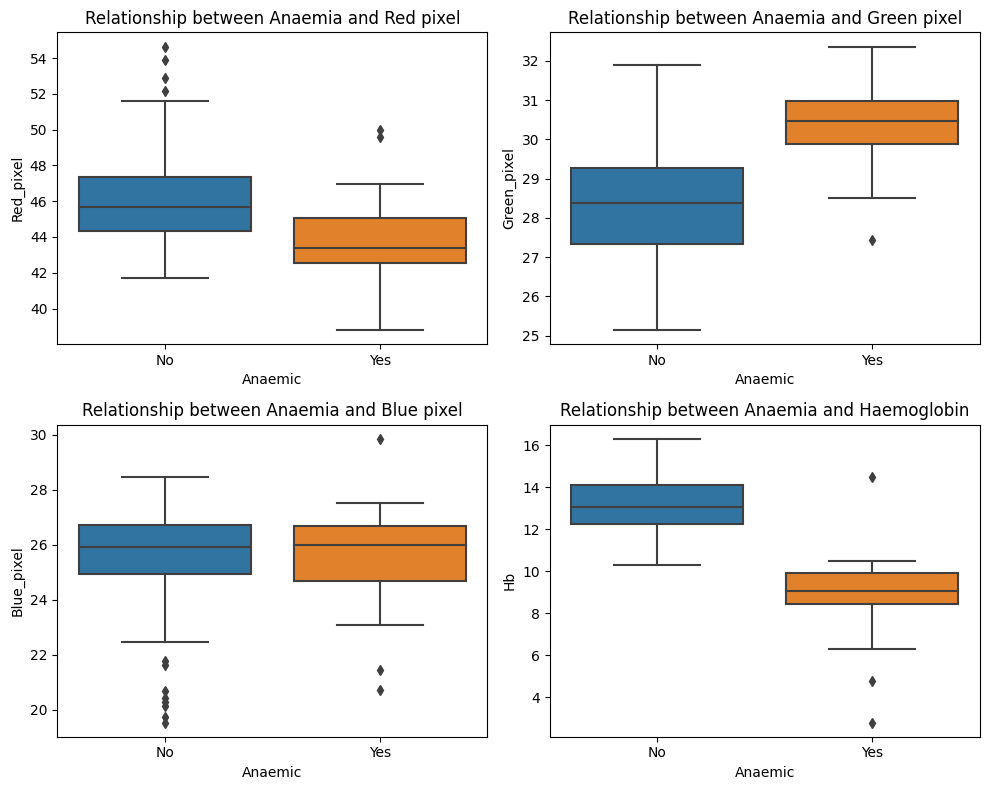

In [16]:
plt.figure(figsize = (10, 8))

plt.subplot(2,2,1)
plt.title('Relationship between Anaemia and Red pixel')
sns.boxplot(data = data, y = 'Red_pixel', x = 'Anaemic')

plt.subplot(2,2,2)
plt.title('Relationship between Anaemia and Green pixel')
sns.boxplot(data = data, y = 'Green_pixel', x = 'Anaemic')

plt.subplot(2,2,3)
plt.title('Relationship between Anaemia and Blue pixel')
sns.boxplot(data = data, y = 'Blue_pixel', x = 'Anaemic')

plt.subplot(2,2,4)
plt.title('Relationship between Anaemia and Haemoglobin')
sns.boxplot(data = data, y = 'Hb', x = 'Anaemic')

plt.tight_layout()
plt.show()

From the boxplots above, you can deduce that:
* The median value of red pixel percentages of anaemic individuals appears to be significantly less than that of nonanaemic individuals.
* The median value of green pixel percentages of anaemic individuals is significantly greater than that of nonanaemic individuals.
* There is no significant difference between the median values of anaemic and nonanaemic individuals.
* The Haemoglogin level of nonanaemic individuals is unsurprisingly ggreater than that of anaemic individuals. However there is an outlier in the data set with very comparatively high Hb level which is counterintuitive. 

In [17]:
df = data.copy()
df.drop('Number', axis = 1, inplace = True)

<Figure size 1000x600 with 0 Axes>

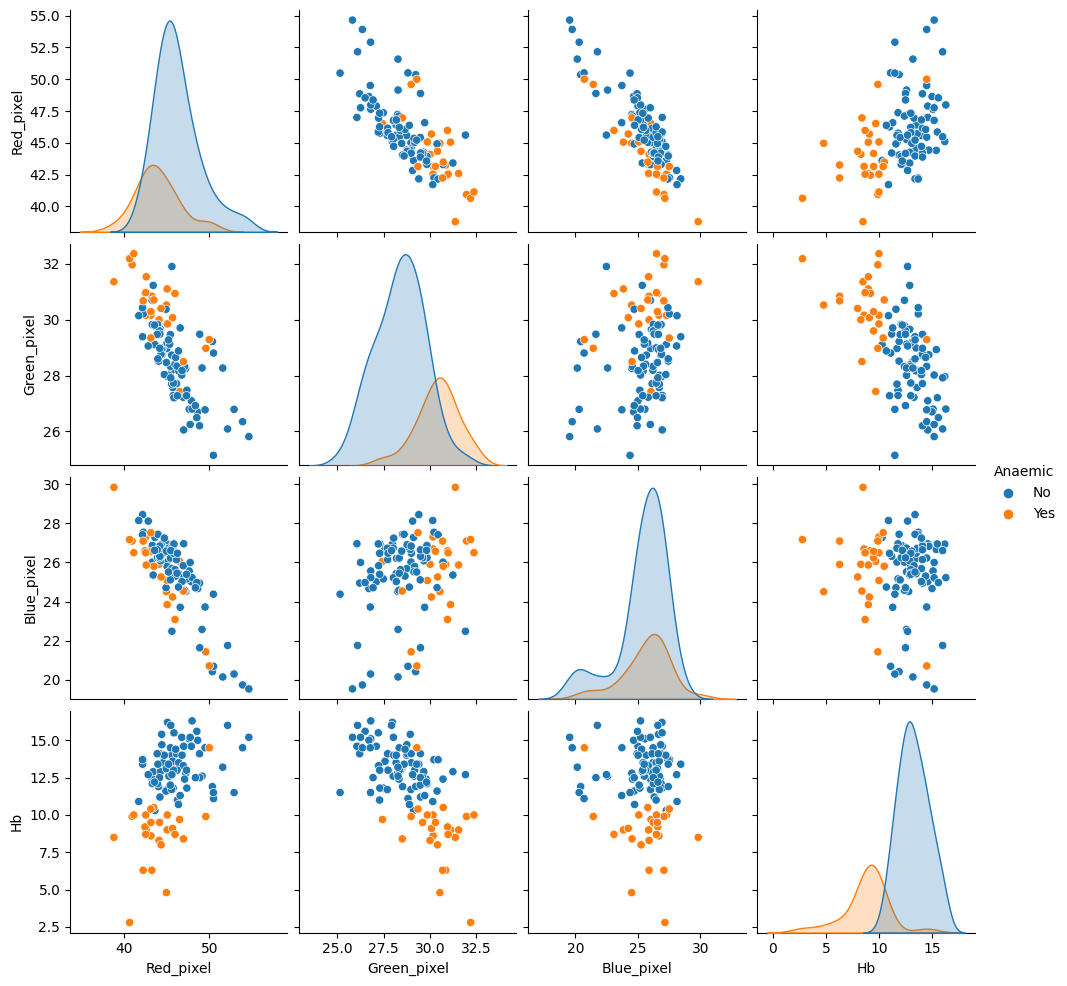

In [18]:
plt.figure(figsize = (10,6))
sns.pairplot(df, hue = 'Anaemic')
plt.show()

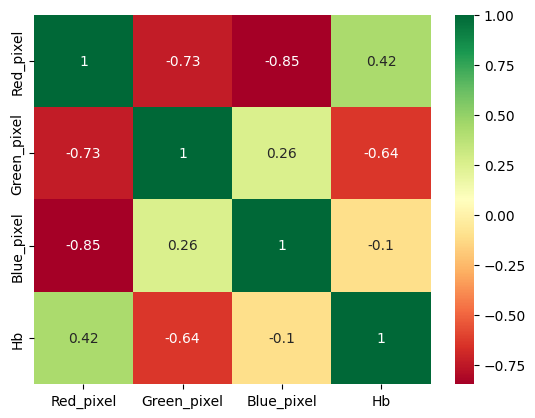

In [19]:
numerical_cols = ['Red_pixel', 'Green_pixel', 'Blue_pixel', 'Hb']
correlation_matrix = df[numerical_cols].corr()

sns.heatmap(correlation_matrix, cmap = 'RdYlGn', annot = True)
plt.show()

From the visualizations above, most of the variables are strongly correlated (negatively correlated).

## Modeling

In [20]:
df['Sex'] = LabelEncoder().fit_transform(df['Sex'])
df['Anaemic'] = LabelEncoder().fit_transform(df['Anaemic'])

X = df.iloc[:,:-1]
y = df.iloc[:,-1:]

scaler = StandardScaler()
X = scaler.fit_transform(X)

print(X.shape, y.shape)

(104, 5) (104, 1)


In [21]:
y = y.to_numpy().reshape(-1,)
print(X.shape, y.shape)

(104, 5) (104,)


In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify = y, random_state = rs)

print(X_train.shape, X_test.shape)

(72, 5) (32, 5)


A user defined function that calculates important classification metrics

In [23]:
def evaluate_metrics(yt, yp):
    results_pos = {}
    results_pos['accuracy'] = accuracy_score(yt, yp)
    precision, recall, f_beta, _ = precision_recall_fscore_support(yt, yp)
    results_pos['recall'] = recall
    results_pos['precision'] = precision
    results_pos['f1score'] = f_beta
    return results_pos

In [24]:
lr = LogisticRegression().fit(X_train, y_train)
y_pred = lr.predict(X_test)

evaluate_metrics(y_test, y_pred)

{'accuracy': 0.90625,
 'recall': array([1.   , 0.625]),
 'precision': array([0.88888889, 1.        ]),
 'f1score': array([0.94117647, 0.76923077])}

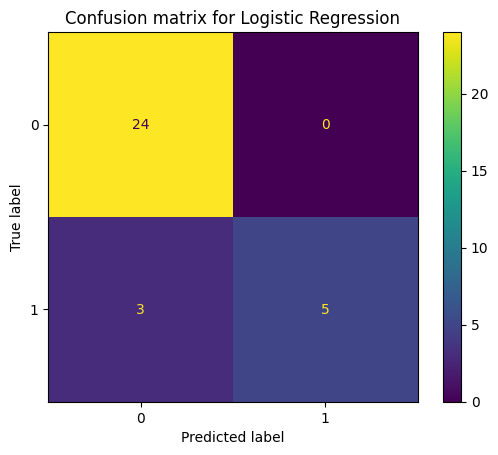

In [25]:
conf_mat = confusion_matrix(y_test, y_pred, )
disp = ConfusionMatrixDisplay(confusion_matrix = conf_mat, display_labels = lr.classes_)
disp.plot() 
plt.title('Confusion matrix for Logistic Regression')
plt.show()

Logistic Regression achieved a 90% accuracy on this dataset, now let's see if applying Principal Component Analysis (a dimension reduction technique) can improve this performance.

In [26]:
pca = PCA(n_components = 2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

print(sum(pca.explained_variance_ratio_))

logreg_pca = LogisticRegression().fit(X_train_pca, y_train)
y_pred = logreg_pca.predict(X_test_pca)

evaluate_metrics(y_test, y_pred)

0.7939247862162724


{'accuracy': 0.875,
 'recall': array([1. , 0.5]),
 'precision': array([0.85714286, 1.        ]),
 'f1score': array([0.92307692, 0.66666667])}

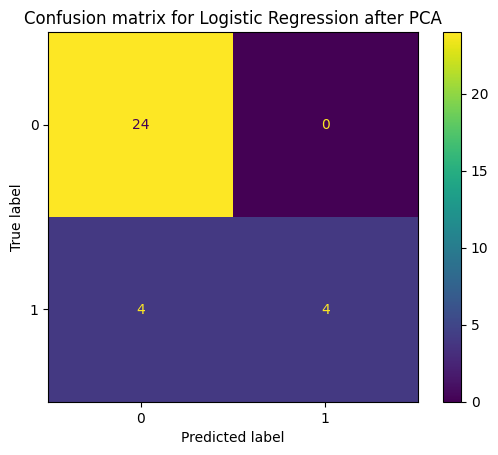

In [27]:
conf_mat = confusion_matrix(y_test, y_pred, )
disp = ConfusionMatrixDisplay(confusion_matrix = conf_mat, display_labels = logreg_pca.classes_)
disp.plot() 
plt.title('Confusion matrix for Logistic Regression after PCA')
plt.show()

The 2 principal components captured approximately 80% of information in our original variables, and when fed into our logistic regression model, it achieved 88% accuracy which is slightly worse than our first model. This could be because the 2 principal components do not capture the maximum amount of information in the original variables

In [28]:
pca = PCA(n_components = 3)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

print(sum(pca.explained_variance_ratio_))

logreg_pca = LogisticRegression().fit(X_train_pca, y_train)
y_pred = logreg_pca.predict(X_test_pca)

evaluate_metrics(y_test, y_pred)

0.9347473821134695


{'accuracy': 0.84375,
 'recall': array([1.   , 0.375]),
 'precision': array([0.82758621, 1.        ]),
 'f1score': array([0.90566038, 0.54545455])}

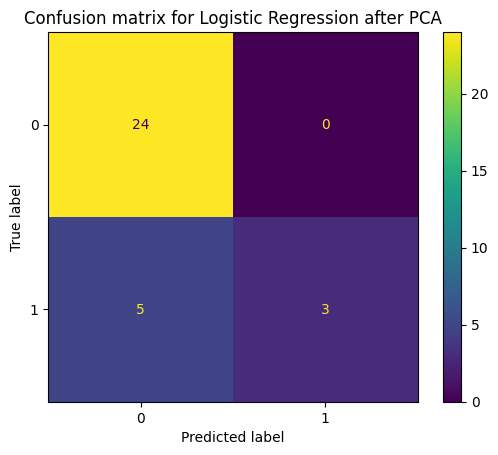

In [29]:
conf_mat = confusion_matrix(y_test, y_pred, )
disp = ConfusionMatrixDisplay(confusion_matrix = conf_mat, display_labels = logreg_pca.classes_)
disp.plot() 
plt.title('Confusion matrix for Logistic Regression after PCA')
plt.show()

3 Principal components although capturing 94% of the information in the original variables performed worse than our initial models with 84% accuracy. This is counterintuitive as you would expect the performance of the model to increase because of the extra information captured by the principal components. This might be because of the dimensionality and the number of observations of the dataset which is comparably small. 